## Turbofan degradation Trane

In [1]:
from util import load_data
df = load_data()

In [2]:
import trane

entity_col = "unit_number"
time_col = "date"
meta = {
    "unit_number": ("Integer", {"numeric", "index"}),
    "time_cycles": ("Integer", {"numeric"}),
}
for col in [col for col in df.columns if col.startswith("s")]:
    meta[col] = ("Double", {"numeric"})
meta["date"] = ("DateTime", {})

cutoff_strategy = trane.CutoffStrategy(
    entity_col="unit_number",
    window_size=None,
    minimum_data="2023-01-01",
)

In [3]:
problem_generator = trane.PredictionProblemGenerator(
    df=df,
    table_meta=meta,
    entity_col=entity_col,
    cutoff_strategy=cutoff_strategy,
    time_col=time_col,
)

In [4]:
problems = problem_generator.generate(df, generate_thresholds=True)

  0%|          | 0/15251 [00:00<?, ?it/s]

In [5]:
ex = problems[0].execute(df, num_examples_per_instance=-1, gap="5d")
problems[0]

Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████| unit_number: 100/100 


For each <unit_number> predict the number of records in next None days

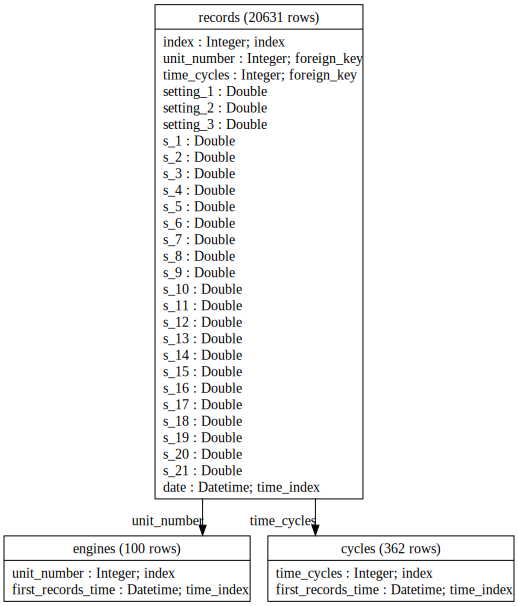

In [6]:
import featuretools as ft
es = ft.EntitySet('observations')

es.add_dataframe(
    dataframe=df.reset_index(),
    dataframe_name='records',
    index='index',
    time_index='date',
)

es.normalize_dataframe(
    base_dataframe_name='records',
    new_dataframe_name='engines',
    index='unit_number',
)

es.normalize_dataframe(
    base_dataframe_name='records',
    new_dataframe_name='cycles',
    index='time_cycles',
)

fm, fd = ft.dfs(
    entityset=es,
    target_dataframe_name='engines',
    cutoff_time=ex,
    agg_primitives=['sum'],
    trans_primitives=[],
    cutoff_time_in_index=True,
    include_cutoff_time=False,
    verbose=False,
)

fm.head()

es.plot()

## ML

In [7]:
fm.reset_index(drop=True, inplace=True)
y = fm.ww.pop('_execute_operations_on_df').astype('category').cat.codes

In [23]:
from sklearn.datasets import load_wine
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
import warnings

models = {
    'LGB': lgb.LGBMRegressor,
    'XGB': xgb.XGBRegressor,
    'DTC': DecisionTreeRegressor,
    'SGDC': SGDRegressor,
    'RF': RandomForestRegressor,
}

def scoring_function(model_name, hyperparameter_values):
    model_class = models[model_name]
    model_instance = model_class(**hyperparameter_values)
    skf = KFold(n_splits=5)
    scores = cross_val_score(
        estimator=model_instance,
        X=fm,
        y=y,
        scoring=make_scorer(mean_squared_error),
        cv=skf,
        n_jobs=-1
    )
    return scores.mean()

from btb.tuning import Tunable
from btb.tuning import hyperparams as hp

tunables = {
    'LGB': Tunable({
        'num_leaves': hp.IntHyperParam(min=2, max=100),
        'max_depth': hp.IntHyperParam(min=3, max=200),
        'learning_rate': hp.FloatHyperParam(min=0.01, max=1),
        'n_estimators': hp.IntHyperParam(min=10, max=1000),
    }),
    'XGB': Tunable({
        'max_depth': hp.IntHyperParam(min=3, max=200),
        'learning_rate': hp.FloatHyperParam(min=0.01, max=1),
        'n_estimators': hp.IntHyperParam(min=10, max=1000),
    }),
    'DTC': Tunable({
        'max_depth': hp.IntHyperParam(min=3, max=200),
        'min_samples_split': hp.FloatHyperParam(min=0.01, max=1)
    }),
    'SGDC': Tunable({
        'max_iter': hp.IntHyperParam(min=1, max=5000, default=1000),
        'tol': hp.FloatHyperParam(min=1e-3, max=1, default=1e-3),
    }),
    'RF': Tunable({
        'n_estimators': hp.IntHyperParam(min=10, max=1000),
        'max_depth': hp.IntHyperParam(min=3, max=200),
        'min_samples_split': hp.FloatHyperParam(min=0.01, max=1),
    }),
}

from btb import BTBSession

session = BTBSession(
    tunables=tunables,
    scorer=scoring_function,
    maximize=False,
    verbose=True
)

best_proposal = session.run(30)

  0%|          | 0/30 [00:00<?, ?it/s]

LGBMRegressor(learning_rate=0.01, max_depth=3, n_estimators=10, num_leaves=2)
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4825
[LightGBM] [Info] Number of data points in the train set: 3349, number of used features: 24
[LightGBM] [Info] Start training from score 112.564348
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4824
[LightGBM] [Info] Number of data points in the train set: 3348, number of used features: 24
[LightGBM] [Info] Start training from score 108.826165
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_row_wise=true` to remove the overhead.
A

/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/s

DecisionTreeRegressor(max_depth=62, min_samples_split=0.1131911839050546)
DecisionTreeRegressor(max_depth=46, min_samples_split=0.3198024716112886)


/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


DecisionTreeRegressor(max_depth=148, min_samples_split=0.6273037568233413)
DecisionTreeRegressor(max_depth=112, min_samples_split=0.451781599775948)
DecisionTreeRegressor(max_depth=36, min_samples_split=0.6101892840348411)


/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


DecisionTreeRegressor(max_depth=165, min_samples_split=0.29832295740881065)
DecisionTreeRegressor(max_depth=77, min_samples_split=0.016724177249461056)
DecisionTreeRegressor(max_depth=24, min_samples_split=0.49184911497375755)


/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


DecisionTreeRegressor(max_depth=111, min_samples_split=0.3797772941985775)
DecisionTreeRegressor(max_depth=132, min_samples_split=0.04551901536797159)


/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


DecisionTreeRegressor(max_depth=101, min_samples_split=0.9935029323439726)
DecisionTreeRegressor(max_depth=113, min_samples_split=0.28389305547013044)


/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


DecisionTreeRegressor(max_depth=20, min_samples_split=0.4898430105845141)
DecisionTreeRegressor(max_depth=18, min_samples_split=0.26788703675960157)


/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [25]:
best_proposal

{'id': '6d3be1ff01935ea1ca6de7ecb7455104',
 'name': 'RF',
 'config': {'n_estimators': 664,
  'max_depth': 69,
  'min_samples_split': 0.14725146278424475},
 'score': 2001.5204320669168}